<a href="https://colab.research.google.com/github/MiladQolami/Mathematical-tools-for-neuroscience/blob/main/Machine_Learning%20/SimpleDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intorduction
In this notebook we build a Deep Neural Network (DNN) for a discrimination task. The task is to discriminate whether a grating bar is oriented clockwise or counterclockwise relative to vertical meridian.



## Dataset Preparation
**Data Generation**

Since this is a specialized dataset, we need to generate synthetic images. Here we want to generate patterns of grating oriented in different direction


In [234]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [235]:
def generate_grating(angle,size=(28,28),frequency=5,noise_level=0.1):

  """
  Genetates sinusoidal grating in image format (PIL)

  Parameters:
      - angle (float): The angle (in degrees) at which the grating pattern is rotated relative to the vertical axis.
                      Positive values rotate the pattern counterclockwise, and negative values rotate it clockwise.
      - size (tuple of ints, optional): The size (width, height) of the output image in pixels.
                      Defaults to (28, 28), which is a common size for small images like those used in image recognition tasks.
      - frequency (float, optional): The frequency of the grating pattern,
                      Defaults to 5.

      Returns:
      - PIL.Image.Image: A PIL Image object containing the generated grating pattern in grayscale (8-bit).
                        The pixel values range from 0 (black) to 255 (white).
  """


  # Create a coordinate grid
  x = np.linspace(-np.pi,np.pi,size[0])
  y = np.linspace(-np.pi,np.pi,size[1])
  X,Y = np.meshgrid(x,y)

  # Rotate the grid by the given angle
  oriRad = np.deg2rad(angle)
  XRot = X * np.cos(oriRad) + Y * np.sin(oriRad)

  grating = np.sin(XRot*frequency)

  # Normalize to [0, 1] and convert to 8-bit grayscale
  gratingNorm = ((grating + 1) / 2 * 255).astype(np.uint8)

      # Add Gaussian noise
  noise = np.random.normal(0, noise_level, grating.shape)
  grating_noisy = grating + noise
  grating_noisy = np.clip(grating_noisy, -1, 1)  # Ensure values are within valid range

    # Normalize to [0, 1] and convert to 8-bit grayscale
  gratingNorm = ((grating_noisy + 1) / 2 * 255).astype(np.uint8)

  return Image.fromarray(gratingNorm)


In [236]:
# Define the number of images and the range of angles
numImage = 1000
angleRange = (-5, 5)  # Angles will vary between -30 and 30 degrees

In [237]:

# Paths to save the images
baseDir = '/content'
clockwiseDir = os.path.join(baseDir, 'clockwise')
counterClockwiseDir = os.path.join(baseDir, 'counterclockwise')
# Create directories if they do not exist
os.makedirs(clockwiseDir, exist_ok=True)
os.makedirs(counterClockwiseDir, exist_ok=True)


def generate_dataset(imageNumber,angleRange):
  """
  Generates a dataset of sin grating withing a range of orientations

  Parameters:
  -imageNumber(integer): number of images
  -angleRange(tuble): minimum and maximum of the orientation range

  Return:


  """

  for image_i in range(imageNumber):

    # generating grating with random orientation
    clockWise = np.random.uniform(.1,angleRange[1])
    counterClockWise = np.random.uniform(angleRange[0],-.1)

    image = generate_grating(clockWise)
    image.save(os.path.join(clockwiseDir,f'clockwise_{image_i}.png'))

    image = generate_grating(counterClockWise)
    image.save(os.path.join(counterClockwiseDir,f'counterclockwise_{image_i}.png'))



generate_dataset(numImage,angleRange)


**Generating Labels and Creating a Balanced Dataset**

The goal is to create a dataset where each image is labeled based on the orientation of the grating (clockwise or counterclockwise). Additionally, we ensure the dataset is balanced, meaning it has an equal number of clockwise and counterclockwise images.

In [238]:
# Collect image paths and labels
data_dir = '/content'
image_paths = []
labels = []

# Loop through the directories for each class
classes = ['clockwise', 'counterclockwise']
for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(label)

# Create a list of indices and shuffle them
indices = list(range(len(labels)))
np.random.shuffle(indices)

# Split indices
train_size = int(0.7 * len(indices))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Get subsets of image_paths and labels
train_image_paths = [image_paths[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]

val_image_paths = [image_paths[i] for i in val_indices]
val_labels = [labels[i] for i in val_indices]

# Define the Dataset class
class GratingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load image and apply transformations
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomAutocontrast(),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.9),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create datasets with appropriate transforms
train_dataset = GratingDataset(train_image_paths, train_labels, transform=train_transform)
val_dataset = GratingDataset(val_image_paths, val_labels, transform=val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

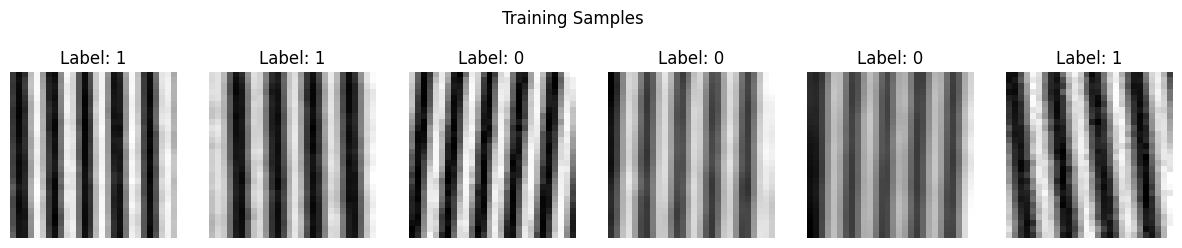

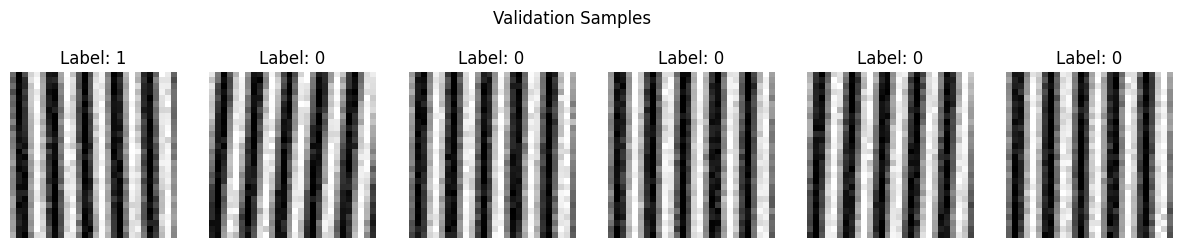

In [239]:

# Function to display images from the dataset
def display_sample_images(dataset, title):
    images, labels = next(iter(DataLoader(dataset, batch_size=6)))
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    for i in range(6):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Display training images
display_sample_images(train_dataset, 'Training Samples')

# Display validation images
display_sample_images(val_dataset, 'Validation Samples')


The next step is to build and define the neural network model that will classify the grating patterns as oriented either clockwise or counterclockwise. This typically involves defining the model architecture, choosing the Loss Function and Optimizer,
writing the training loop and evaluating the model.

### How the images look like after transformation?

Here we choose a fully connected deep neuroal network, although it is not an ideal model atchitecture for image classification.


In [240]:

class GratingDNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=5, num_classes=2):
        super(GratingDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer to hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Hidden layer to hidden layer
        self.fc3 = nn.Linear(hidden_size, num_classes) # Hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 28*28)             # Flatten the 28x28 image to a 784 vector
        x = F.relu(self.fc1(x))            # First hidden layer with ReLU activation
        x = F.relu(self.fc2(x))            # Second hidden layer with ReLU activation
        x = self.fc3(x)                    # Output layer (no activation, will use CrossEntropyLoss)
        return x


In [241]:
class GratingCNN(nn.Module):
    def __init__(self):
        super(GratingCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Convolutional layer
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsampling
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 7 * 7, 64),  # Adjust the size according to the image size
            nn.ReLU(),
            nn.Linear(64, 2)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layer(x)
        return x

model = GratingCNN()


In [242]:
model = GratingDNN()
loss_function = nn.CrossEntropyLoss()              # For classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer


In [243]:
num_epochs = 10 # Number of epochs

for epoch in range(num_epochs):
    model.train()                              # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()                  # Zero gradients
        outputs = model(images)                # Forward pass
        loss = loss_function(outputs, labels)      # Compute loss
        loss.backward()                        # Backward pass
        optimizer.step()                       # Update weights

        running_loss += loss.item()

    # Print average loss per epoch
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Validation phase
    model.eval()                               # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.6765
Validation Accuracy: 92.83%
Epoch [2/10], Loss: 0.6154
Validation Accuracy: 89.00%
Epoch [3/10], Loss: 0.5566
Validation Accuracy: 95.00%
Epoch [4/10], Loss: 0.4871
Validation Accuracy: 93.00%
Epoch [5/10], Loss: 0.4535
Validation Accuracy: 96.33%
Epoch [6/10], Loss: 0.4316
Validation Accuracy: 99.67%
Epoch [7/10], Loss: 0.4009
Validation Accuracy: 99.50%
Epoch [8/10], Loss: 0.3712
Validation Accuracy: 99.67%
Epoch [9/10], Loss: 0.3838
Validation Accuracy: 99.83%
Epoch [10/10], Loss: 0.3509
Validation Accuracy: 99.83%
